In [1]:
import os
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.io import read_image, ImageReadMode
import segmentation_models_pytorch as smp
from sklearn.metrics import average_precision_score
%matplotlib inline

C:\Users\lilar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = 'tiff_copy2'
bs = 16

transform1 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.406, 0.456, 0.485], std=[0.225, 0.224, 0.229])
        ])

transform2 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=0.5, std=0.25)
        ])

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [4]:
train_path = os.path.join(data_path, 'train')
train_labels_path = os.path.join(data_path, 'train_labels')

test_path = os.path.join(data_path, 'test')
test_labels_path = os.path.join(data_path, 'test_labels')

val_path = os.path.join(data_path, 'val')
val_labels_path = os.path.join(data_path, 'val_labels')

In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.images_path = images
        self.labels_path = labels
        
        self.images  = os.listdir(images)
        self.labels = os.listdir(labels)
        
        self.transform  = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_path, self.images[index])
        mask_path = os.path.join(self.labels_path, self.labels[index])
        image = Image.open(img_path)
        label = Image.open(mask_path)

        bw_image_array = np.array(label)
        color_image_array = np.array(image)

        top_left_x = random.randint(0, 500 - 224)
        top_left_y = random.randint(0, 500 - 224)
            
        bw_square = bw_image_array[top_left_y:top_left_y + 224, top_left_x:top_left_x + 224]
            
        color_square = color_image_array[top_left_y:top_left_y + 224, top_left_x:top_left_x + 224, :]

        white_pixels = np.sum(bw_square == 255)
        total_pixels = np.prod(bw_square.shape)
        while (white_pixels / total_pixels) < 0.02:
            top_left_x = random.randint(0, 500 - 224)
            top_left_y = random.randint(0, 500 - 224)
            bw_square = bw_image_array[top_left_y:top_left_y + 224, top_left_x:top_left_x + 224]
            color_square = color_image_array[top_left_y:top_left_y + 224, top_left_x:top_left_x + 224, :]
            white_pixels = np.sum(bw_square == 255)
            total_pixels = np.prod(bw_square.shape)

            
        bw_square_image = Image.fromarray(bw_square)
        color_square_image = Image.fromarray(color_square)
        
        if self.transform:
            image = self.transform(color_square_image)
        if self.target_transform:
            label = self.target_transform(bw_square_image)
            label = torch.cat([label], dim=0)
        
        return image, label

In [6]:
custom_dataset = CustomDataset(train_path, train_labels_path,  transform1, transform2)
train_loader = DataLoader(custom_dataset, batch_size=bs, shuffle=True)

custom_dataset = CustomDataset(test_path, test_labels_path, transform1, transform2)
test_loader = DataLoader(custom_dataset, batch_size=bs, shuffle=False)

custom_dataset = CustomDataset(val_path, val_labels_path, transform1, transform2)
val_loader = DataLoader(custom_dataset, batch_size=bs, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


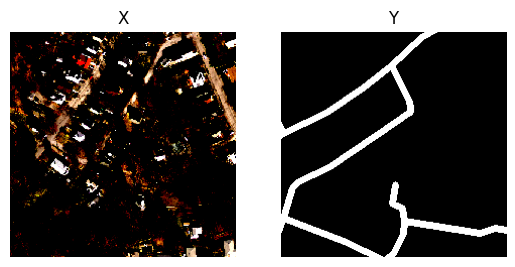

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


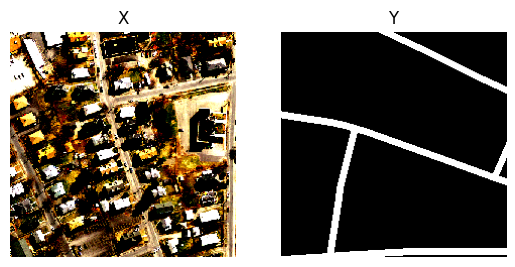

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


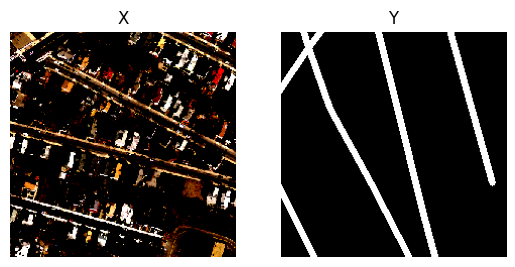

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


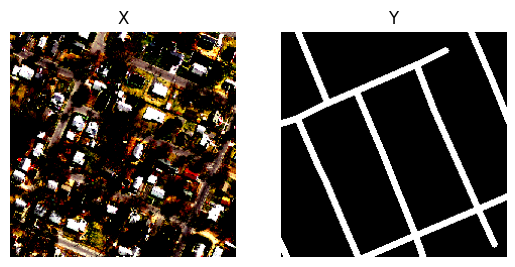

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


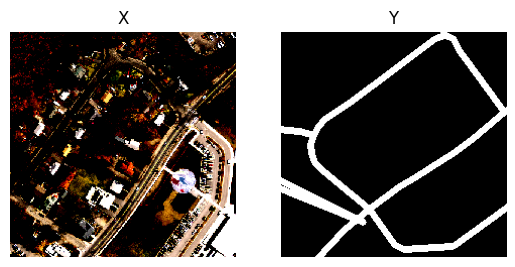

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


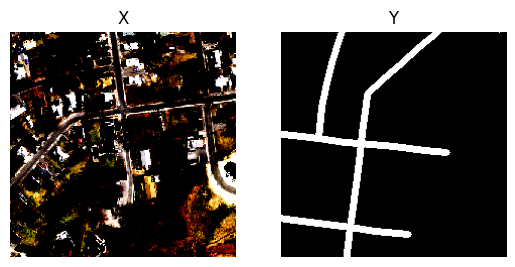

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


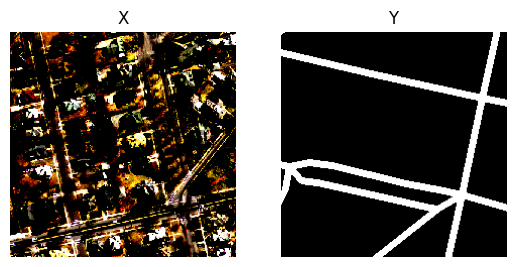

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


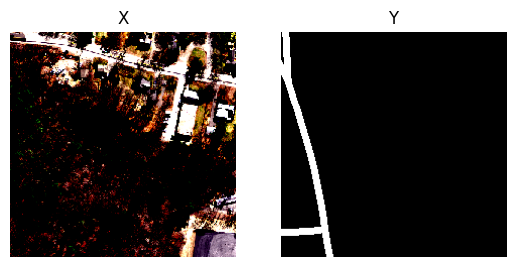

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


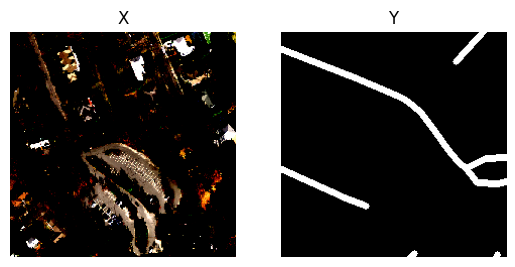

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


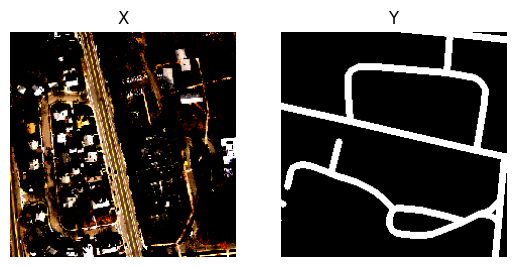

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


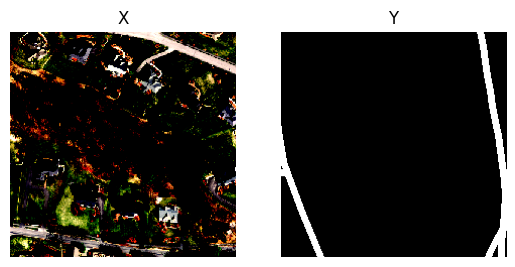

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


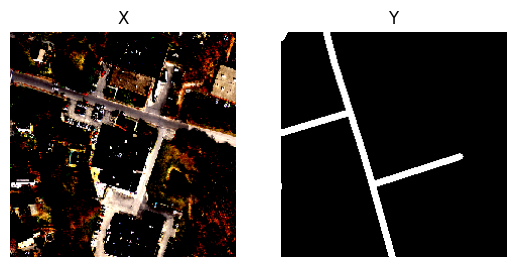

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


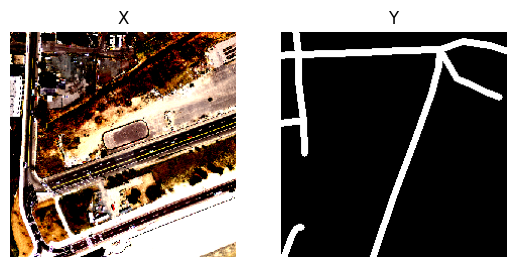

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


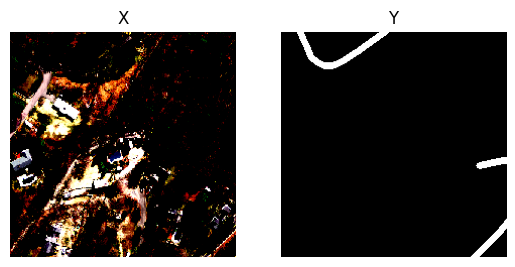

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


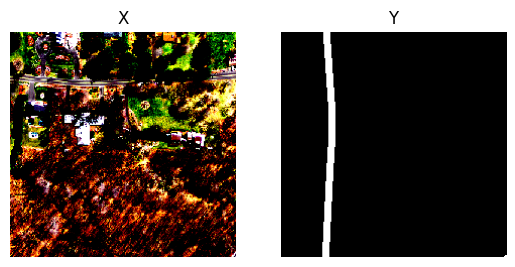

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


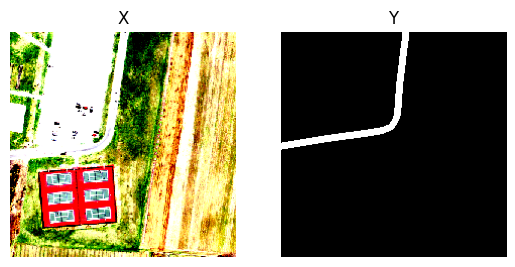

In [7]:
for images, labels in train_loader:
    for i in range(len(images)):
        
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(images[i].numpy()))
        plt.title('X')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(labels[i].numpy().squeeze(), cmap='gray')
        plt.title('Y')
        plt.axis('off')

        plt.show()
    break
    

In [8]:
model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1)

model = model.to(device)
# model.load_state_dict(torch.load('UNet_ResNet34_30_2.pth'))
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
num_epochs = 10
len_train_loader = len(train_loader)
len_val_loader = len(val_loader)

train_loss_arr = []
val_loss_arr = []

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

In [10]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_total_iou = 0.0
    train_total_precision = 0.0
    train_total_recall = 0.0
    train_iou_arr = []
    train_precision_arr = []
    train_recall_arr = []
    
    i = 1
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        print(f'\rIteration: {i} / {len_train_loader}', end='', flush=True)
        targets[targets == -2] = 0
        targets[targets == 2] = 1

        inputs = inputs.to(device)
        
        targets = targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss_arr.append(loss.item())
        
        predicted_masks = (outputs > 0.5).float()

        intersection = torch.logical_and(predicted_masks, targets).sum().item()
        union = torch.logical_or(predicted_masks, targets).sum().item()
        iou = intersection / union if union != 0 else 0
        train_total_iou += iou
        train_iou_arr.append(iou)

        
        TP = ((predicted_masks == 1) & (targets == 1)).sum().item()
        FP = ((predicted_masks == 1) & (targets == 0)).sum().item()
        FN = ((predicted_masks == 0) & (targets == 1)).sum().item()

        precision = TP / (TP + FP) if TP + FP > 0 else 0.0
        recall = TP / (TP + FN) if TP + FN > 0 else 0.0

        train_total_precision += precision
        train_total_recall += recall

        train_precision_arr.append(precision)
        train_recall_arr.append(recall)
        
        i += 1
        
        # for i in range(len(inputs)):
        #     fig, axs = plt.subplots(1, 3, figsize=(10, 5))

        #     axs[0].imshow(predicted_masks[i][0].cpu(), cmap='binary')
        #     axs[0].axis('off')
        #     axs[0].set_title('Predicted Mask')

        #     axs[1].imshow(targets[i][0].cpu(), cmap='binary')
        #     axs[1].axis('off')
        #     axs[1].set_title('True Mask')

        #     axs[2].imshow(inputs[i][0].cpu())
        #     axs[2].axis('off')
        #     axs[2].set_title('Input Train')

        #     plt.show()
        # print(iou)

        # break
        

    scheduler.step()
    

    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # axs[0].imshow(iou_arr)
    # axs[0].axis('off')
    # axs[0].set_title('IoU')

    # axs[1].imshow(map_arr)
    # axs[1].axis('off')
    # axs[1].set_title('MAP')

    # plt.show()
 
    model.eval()
    val_loss = 0.0
    val_total_iou = 0.0
    val_total_precision = 0.0
    val_total_recall = 0.0
    val_precision_arr = []
    val_recall_arr = []
    j = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            targets[targets == -2] = 0
            targets[targets == 2] = 1
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_loss_arr.append(loss.item())
            
            predicted_masks = (outputs > 0.5).float()

            # for i in range(len(inputs)):
            #     fig, axs = plt.subplots(1, 3, figsize=(10, 5))

            #     axs[0].imshow(predicted_masks[i][0].cpu(), cmap='binary')
            #     axs[0].axis('off')
            #     axs[0].set_title('Predicted Mask')

            #     axs[1].imshow(targets[i][0].cpu(), cmap='binary')
            #     axs[1].axis('off')
            #     axs[1].set_title('True Mask')

            #     axs[2].imshow(inputs[i][0].cpu())
            #     axs[2].axis('off')
            #     axs[2].set_title('Input')

            #     plt.show()
            
            intersection = torch.logical_and(predicted_masks, targets).sum().item()
            union = torch.logical_or(predicted_masks, targets).sum().item()
            iou = intersection / union if union != 0 else 0
            val_total_iou += iou

            TP = ((predicted_masks == 1) & (targets == 1)).sum().item()
            FP = ((predicted_masks == 1) & (targets == 0)).sum().item()
            FN = ((predicted_masks == 0) & (targets == 1)).sum().item()

            precision = TP / (TP + FP) if TP + FP > 0 else 0.0
            recall = TP / (TP + FN) if TP + FN > 0 else 0.0

            val_total_precision += precision
            val_total_recall += recall

            val_precision_arr.append(precision)
            val_recall_arr.append(recall)
        
            # debug
            # print(iou)
            # print(predicted_masks[0][0][0][0].item(), targets[0][0][0][0].item())
            # unique_values1 = torch.unique(predicted_masks)
            # unique_values2 = torch.unique(targets)
            # print(unique_values1, unique_values2)
            # # break
    
    
    print(f'\nEpoch {epoch + 1}:')
    print(f'Training Loss: {train_loss / len_train_loader}') 
    print(f'Validation Loss: {val_loss / len_val_loader}')
    print(f'Training precision: {train_total_precision / len_train_loader}')
    print(f'Validation precision: {val_total_precision / len_val_loader}')
    print(f'Training recall: {train_total_recall / len_train_loader}')
    print(f'Validation recall: {val_total_recall / len_val_loader}')
    print(f'Training IOU: {train_total_iou / len_train_loader}')
    print(f'Validation IOU: {val_total_iou / len_val_loader}\n')
    
print("That's all")

Iteration: 367 / 367
Epoch 1:
Training Loss: 0.1475322432714522
Validation Loss: 0.17425031960010529
Training precision: 0.7608820474563776
Validation precision: 0.8010616504940629
Training recall: 0.37990983046060034
Validation recall: 0.40075974749935656
Training IOU: 0.33997508292537776
Validation IOU: 0.36206956539362334

Iteration: 367 / 367
Epoch 2:
Training Loss: 0.12374233285964997
Validation Loss: 0.14593546092510223
Training precision: 0.8117498690962321
Validation precision: 0.8400719775255026
Training recall: 0.4862280090236674
Validation recall: 0.4072346441569266
Training IOU: 0.43594435096118006
Validation IOU: 0.3773024295968198

Iteration: 367 / 367
Epoch 3:
Training Loss: 0.1186298187365324
Validation Loss: 0.1674535572528839
Training precision: 0.8226612809420204
Validation precision: 0.712044373084516
Training recall: 0.5113459602973096
Validation recall: 0.5709361846716826
Training IOU: 0.4597860639338758
Validation IOU: 0.46364071020574976

Iteration: 367 / 367
Ep

In [11]:
model.eval()
test_loss = 0.0
test_total_iou = 0.0
test_total_precision = 0.0
test_total_recall = 0.0
test_precision_arr = []
test_recall_arr = []

with torch.no_grad():
    for inputs, targets in test_loader:

        targets[targets == -2] = 0
        targets[targets == 2] = 1

        inputs = inputs.to(device)
        targets = targets.to(device)
             
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
            
        predicted_masks = (outputs > 0.5).float()
        intersection = torch.logical_and(predicted_masks, targets).sum().item()
        union = torch.logical_or(predicted_masks, targets).sum().item()
        iou = intersection / union if union != 0 else 0
        test_total_iou += iou

        TP = ((predicted_masks == 1) & (targets == 1)).sum().item()
        FP = ((predicted_masks == 1) & (targets == 0)).sum().item()
        FN = ((predicted_masks == 0) & (targets == 1)).sum().item()

        precision = TP / (TP + FP) if TP + FP > 0 else 0.0
        recall = TP / (TP + FN) if TP + FN > 0 else 0.0

        test_total_precision += precision
        test_total_recall += recall

        test_precision_arr.append(precision)
        test_recall_arr.append(recall)
            
        # for i in range(len(inputs)):
        #     fig, axs = plt.subplots(1, 3, figsize=(10, 5))

        #     axs[0].imshow(predicted_masks[i][0].cpu(), cmap='binary')
        #     axs[0].axis('off')
        #     axs[0].set_title('Predicted Mask')

        #     axs[1].imshow(targets[i][0].cpu(), cmap='binary')
        #     axs[1].axis('off')
        #     axs[1].set_title('True Mask')

        #     axs[2].imshow(inputs[i][0].cpu())
        #     axs[2].axis('off')
        #     axs[2].set_title('Input')

        #     plt.show()

        # print(iou)
        # print(predicted_masks[0][0][0][0].item(), targets[0][0][0][0].item())
        # unique_values1 = torch.unique(predicted_masks)
        # unique_values2 = torch.unique(targets)
        # print(unique_values1, unique_values2)


print(f'Test Loss: {test_loss / len(test_loader)}')
print(f'Test precision: {test_total_precision / len(test_loader)}')
print(f'Test recall: {test_total_recall / len(test_loader)}')
print(f'Test IOU: {test_total_iou / len(test_loader)}')

Test Loss: 0.07850473232212521
Test precision: 0.8741736718104224
Test recall: 0.636226096109831
Test IOU: 0.5835983972087811


In [12]:
torch.save(model.state_dict(), 'UNet_ResNet34_10_total.pth')